In [1]:
from model_src.model import Model
from model_src.model_setup import model_setup
from utils.tensorboard import TBoardGraphs
from utils.dataset import Dataset
import hashids
import time
import os
from model_src.network import Network
from torch.utils.data import DataLoader
import torch
import higher
from utils.simulation import ToySimulation
from utils.utils import check_outpt

2022-06-10 00:03:52.669714: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hendrik/Documents/master_project/Code/LanguagePolicies/ros2/src/install/policy_translation/lib:/opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/foxy/lib/x86_64-linux-gnu:/opt/ros/foxy/lib::/home/hendrik/Documents/master_project/CoppeliaSim_Player_V4_1_0_Ubuntu20_04:/home/hendrik/.mujoco/mujoco200/bin
2022-06-10 00:03:52.669737: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


torch.Size([10000, 5, 4])


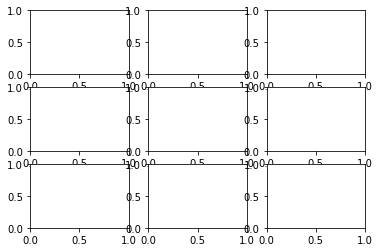

In [2]:
hid = hashids.Hashids()
logname = hid.encode(int(time.time() * 1000000))
data_path = '/home/hendrik/Documents/master_project/LokalData/'
tboard = TBoardGraphs(logname=logname, data_path=data_path)
path_dict = {
        'META_WORLD' : os.path.join(data_path, 'metaworld/small/'),
        'DATA_PATH' : data_path
        }
train_path = path_dict['META_WORLD'] + 'train/'
val_path = path_dict['META_WORLD'] + 'val/'
test_path = path_dict['META_WORLD'] + 'test/'
tol_path = path_dict['META_WORLD'] + 'tol/'
train_data = Dataset(path=train_path, device='cuda')
data_shape = train_data.s_trajectories.shape

print(data_shape)
model_setup['seq_len'] = data_shape[1]
model_setup['decoder']['d_output'] = data_shape[-1]
val_data = Dataset(path=val_path, device='cuda')
test_data = Dataset(path=test_path, device='cuda')
datasets = {'train':train_data, 'val':val_data}
model_lr = 1e-5
critic_lr = 1e-5
model = Model(model_setup=model_setup, opt_lr=1, writer=tboard, iterations=2).to('cuda')
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
for succ, fail in train_loader:
        obsv, label, succ = succ
        break
tol_neg = -0.30*torch.ones([label.size(-1)], device='cuda')
tol_pos = 0.45*torch.ones([label.size(-1)], device='cuda')
simulation = ToySimulation(neg_tol=tol_neg, pos_tol=tol_pos, check_outpt_fct=check_outpt, result_size=label.size(-1), window=0, dataset=test_data)



In [3]:
network = Network(model=model, data_sets=datasets, model_lr=model_lr, critic_lr=critic_lr, batchsize=32, tboard=tboard, simulation=simulation)

obsv:torch.Size([32, 4])


In [4]:
network.train(epochs=200)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
network.simulate(num_envs=200, policy=network.model)

In [ ]:
model = Model(model_setup=model_setup, opt_lr=1, writer=tboard)

TypeError: __init__() missing 1 required positional argument: 'iterations'

In [ ]:
opt = torch.optim.AdamW(params=model.parameters(), lr=1e-4)
with torch.no_grad():
    erg,_,_ =model.forward(succ[0])
h = time.perf_counter()
def mse(a,b):
    return ((a-b)**2).mean()

for succ, fail in train_loader:
    erg,_,_ =model.forward(succ[0])
    loss = mse(erg, succ[1])
    loss.backward()
    opt.step()
print(time.perf_counter() - h)




IndexError: dimension specified as 0 but tensor has no dimensions

In [ ]:
from model_src.model import Model
from model_src.model_setup import model_setup
from utils.tensorboard import TBoardGraphs
from utils.dataset import Dataset
import hashids
import time
import os
from model_src.network import Network
from torch.utils.data import DataLoader
import torch
import higher

In [ ]:
hid = hashids.Hashids()
logname = hid.encode(int(time.time() * 1000000))
data_path = '/home/hendrik/Documents/master_project/LokalData/'
tboard = TBoardGraphs(logname=logname, data_path=data_path)
path_dict = {
        'META_WORLD' : os.path.join(data_path, 'metaworld/small/'),
        'DATA_PATH' : data_path
        }
train_path = path_dict['META_WORLD'] + 'train/'
val_path = path_dict['META_WORLD'] + 'val/'
test_path = path_dict['META_WORLD'] + 'test/'
tol_path = path_dict['META_WORLD'] + 'tol/'
train_data = Dataset(path=train_path, device='cuda')
data_shape = train_data.s_trajectories.shape
model_setup['seq_len'] = data_shape[1]
model_setup['decoder']['d_output'] = data_shape[-1]
val_data = Dataset(path=val_path)
datasets = {'train':train_data, 'val':val_data}
model_lr = 1e-4
seq_decoder_lr = 1e-4
critic_lr = 1e-4
model = Model(model_setup=model_setup, opt_lr=1, writer=tboard)
def mse(a,b):
    return ((a-b)**2).mean()

In [ ]:
model = Model(model_setup=model_setup, opt_lr=1, writer=tboard).to('cuda')

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

with torch.no_grad():
    for succ, fail in train_loader:
        erg,_,_ =model.forward(succ[0])
        break
opt = torch.optim.AdamW(model.parameters())
h = time.perf_counter()
with higher.innerloop_ctx(model, opt, copy_initial_weights=False, track_higher_grads=False) as (fmodel, diffopt):
    for succ, fail in train_loader:
        erg,_,_ =fmodel.forward(succ[0])
        loss = mse(erg, succ[1])
        diffopt.step(loss)
print(time.perf_counter() - h)